________
<a id="top"></a>
# DS 7331 Data Mining: Mini Lab 2 iPython Notebook
Created On: February 11, 2019
### Authors:  
- Arora, Tanvi                
- Chandna, Rajat
- Henderson Kuns, Nicol
- Ramasundaram, Kumar
- Vasquez, James
LRInterpertFeat

# Logisitic Regression and Support Vector Machines

## Contents
* <a href="#DataPrep">Data Prepping</a>
    * <a href="#onehotencode">One Hot Encoding</a>
    * <a href="#Perform8020split">Perform 80/20 split</a>  
    * <a href="#PrepTestData">Prep Test Data</a>    
* <a href="#CreateLRModel">Create Models</a>
    * <a href="#CreateLRModel">Simple Logistic Regression Model</a>  
    * <a href="#LRGridSearch">Grid Search</a>   
    * <a href="#LRInterpertFeat">Feature Interpertation</a>   
* <a href="#SVMModel">Simple SVM Model</a>
    * <a href="#SVMRBF">RBF Grid Search</a>   
    * <a href="#SVMPOLY">Poly Grid Search</a>   
    * <a href="#SVMFINAL">Final SVM Model on Validation Dataset</a>
    * <a href="#SVMFINAL_Test">Final SVM Model on Additional Test Dataset</a> 
* <a href="#MODELADV">Model Advantages</a>
* <a href="#INTVECT">Interpret Support Vector</a>
* <a href="#ECPWORK">Exceptionnal Work</a>

<a id="DataPrep"></a>
### Getting Dataset Ready for Model Building

In [1]:
# Importing the needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

# To display plots inside the iPython Notebook itself
%matplotlib inline

In [5]:
# To verify how data is orgainzed in file(to find the delimiter) and then
# use corresponding function to open the file. eg
# data could be in .csv. .tsv, excel format etc.
pathOfDataFile = "data/bank-full.csv"
firstFewLines = list()
noOfLinesToView = 5

with open(pathOfDataFile) as dataFile:
    firstFewLines = [next(dataFile) for i in range(noOfLinesToView)]
    for line in firstFewLines:
        print(line)

FileNotFoundError: [Errno 2] No such file or directory: 'data/bank-full.csv'

In [3]:
# Import the semi-colon delimited data file into pandas dataFrame
bankPromo_df = pd.read_csv(pathOfDataFile, sep = ";")

# Rename the Target/Final Outcome column from "y" to "Subscribed" as based on data description.
bankPromo_df = bankPromo_df.rename(columns={"y":"Subscribed"})

bankPromo_df.head(7)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Subscribed
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no


In [4]:
bankPromo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age           45211 non-null int64
job           45211 non-null object
marital       45211 non-null object
education     45211 non-null object
default       45211 non-null object
balance       45211 non-null int64
housing       45211 non-null object
loan          45211 non-null object
contact       45211 non-null object
day           45211 non-null int64
month         45211 non-null object
duration      45211 non-null int64
campaign      45211 non-null int64
pdays         45211 non-null int64
previous      45211 non-null int64
poutcome      45211 non-null object
Subscribed    45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# Get the unique values(Levels) for categorical variables.
# List to hold names of categorical variables
categoricalVars = list()
# List to hold names of numerical variables
numericalVars = list()

for colName in bankPromo_df.columns:
    if bankPromo_df[colName].dtype == np.int64:
        numericalVars.append(colName)
    elif bankPromo_df[colName].dtype == np.object:
        categoricalVars.append(colName)
    else:
        pass
    
# Remove Target column from final categorical Var list
categoricalVars.remove('Subscribed')

print(numericalVars)
print(categoricalVars)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


________________________________________________________________________________________________________
<a id="onehotencode"></a>
<a href="#top">Back to Top</a>
### Perform One Hot Encoding for categorical variables in dataset

In [6]:
# Make a copy of original data frame
bankPromoModel_Df = bankPromo_df.copy()
bankPromoModel_Df['Target'] = bankPromoModel_Df['Subscribed'].apply(lambda resp : 1 if resp == "yes" else 0)
bankPromoModel_Df['Target'] = bankPromoModel_Df['Target'].astype(np.int)
# Delete the original 'Subscribed' column
del bankPromoModel_Df['Subscribed']





In [7]:
# Covert all categorical variables to corresponding indicator variables
for categoricalVar in categoricalVars:
    tmpDf = pd.DataFrame()
    # Remove 1st class level to avoid multicollinearity
    tmpDf = pd.get_dummies(bankPromoModel_Df[categoricalVar], prefix=categoricalVar, drop_first=True)
    bankPromoModel_Df = pd.concat((bankPromoModel_Df, tmpDf), axis=1)

# Now remove the original categorical vars since indicator variables are created from them.
bankPromoModel_Df.drop(categoricalVars, inplace=True, axis=1)
bankPromoModel_Df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 43 columns):
age                    45211 non-null int64
balance                45211 non-null int64
day                    45211 non-null int64
duration               45211 non-null int64
campaign               45211 non-null int64
pdays                  45211 non-null int64
previous               45211 non-null int64
Target                 45211 non-null int64
job_blue-collar        45211 non-null uint8
job_entrepreneur       45211 non-null uint8
job_housemaid          45211 non-null uint8
job_management         45211 non-null uint8
job_retired            45211 non-null uint8
job_self-employed      45211 non-null uint8
job_services           45211 non-null uint8
job_student            45211 non-null uint8
job_technician         45211 non-null uint8
job_unemployed         45211 non-null uint8
job_unknown            45211 non-null uint8
marital_married        45211 non-null uint8
marital_sin

________________________________________________________________________________________________________
________________________________________________________________________________________________________
<a id="Perform8020split"></a>
<a href="#top">Back to Top</a>
### Perform 5 fold Cross Validation with 80/20 Split for Model Selection 

In [8]:
# Training and Test Split
from sklearn.model_selection import ShuffleSplit

if 'Target' in bankPromoModel_Df:
    y = bankPromoModel_Df['Target'].values # get the labels we want
    del bankPromoModel_Df['Target']        # get rid of the class label
    X = bankPromoModel_Df.values           # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# To use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=999)
                         
print(cv_object)


ShuffleSplit(n_splits=5, random_state=999, test_size=0.2, train_size=None)


________________________________________________________________________________________________________
<a id="PrepTestData"></a>
<a href="#top">Back to Top</a>
### Getting ready Additional Test Dataset(with 10% instances) for final model fitting and weights interpretation 

In [9]:
pathOfAdditionalDataFile = "data/bank.csv"

# Import the semi-colon delimited data file into pandas dataFrame
bankPromoAdditional_df = pd.read_csv(pathOfAdditionalDataFile, sep = ";")

# Rename the Target/Final Outcome column from "y" to "Subscribed" as based on data description.
bankPromoAdditional_df = bankPromoAdditional_df.rename(columns={"y":"Subscribed"})

bankPromoAdditional_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age           4521 non-null int64
job           4521 non-null object
marital       4521 non-null object
education     4521 non-null object
default       4521 non-null object
balance       4521 non-null int64
housing       4521 non-null object
loan          4521 non-null object
contact       4521 non-null object
day           4521 non-null int64
month         4521 non-null object
duration      4521 non-null int64
campaign      4521 non-null int64
pdays         4521 non-null int64
previous      4521 non-null int64
poutcome      4521 non-null object
Subscribed    4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB


In [10]:
bankPromoAdditional_df['Target'] = bankPromoAdditional_df['Subscribed'].apply(lambda resp : 1 if resp == "yes" else 0)
bankPromoAdditional_df['Target'] = bankPromoAdditional_df['Target'].astype(np.int)
# Delete the original 'Subscribed' column
del bankPromoAdditional_df['Subscribed']

In [11]:
# Covert all categorical variables to corresponding indicator variables
for categoricalVar in categoricalVars:
    tmpDf = pd.DataFrame()
    # Remove 1st class level to avoid multicollinearity
    tmpDf = pd.get_dummies(bankPromoAdditional_df[categoricalVar], prefix=categoricalVar, drop_first=True)
    bankPromoAdditional_df = pd.concat((bankPromoAdditional_df, tmpDf), axis=1)

# Now remove the original categorical vars since indicator variables are created from them.
bankPromoAdditional_df.drop(categoricalVars, inplace=True, axis=1)

if 'Target' in bankPromoAdditional_df:
    y_Final = bankPromoAdditional_df['Target'].values # get the labels we want
    del bankPromoAdditional_df['Target']        # get rid of the class label
    X_Final = bankPromoAdditional_df.values

bankPromoAdditional_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 42 columns):
age                    4521 non-null int64
balance                4521 non-null int64
day                    4521 non-null int64
duration               4521 non-null int64
campaign               4521 non-null int64
pdays                  4521 non-null int64
previous               4521 non-null int64
job_blue-collar        4521 non-null uint8
job_entrepreneur       4521 non-null uint8
job_housemaid          4521 non-null uint8
job_management         4521 non-null uint8
job_retired            4521 non-null uint8
job_self-employed      4521 non-null uint8
job_services           4521 non-null uint8
job_student            4521 non-null uint8
job_technician         4521 non-null uint8
job_unemployed         4521 non-null uint8
job_unknown            4521 non-null uint8
marital_married        4521 non-null uint8
marital_single         4521 non-null uint8
education_secondary    4521 non-n

________________________________________________________________________________________________________
<a id="CreateLRModel"></a>
<a href="#top">Back to Top</a>
# Create Model
### Simple Logistic Model Fit

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

# Standardize the features first, since standardizing the features could lead to
# gradient desent algo to converge faster and then run logistic regression model

logisticModel = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=999))

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
       
    # train the reusable logisitc regression model on the training data
    logisticModel.fit(X_train,y_train)  # train object
    y_hat = logisticModel.predict(X_test) # get test set precitions

    # now let's get the accuracy,precision,recall,auc,F1 and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
  
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())


====Iteration 0  ====
confusion matrix
 [[7769  207]
 [ 706  361]]
====Iteration 1  ====
confusion matrix
 [[7833  184]
 [ 680  346]]
====Iteration 2  ====
confusion matrix
 [[7736  201]
 [ 703  403]]
====Iteration 3  ====
confusion matrix
 [[7772  207]
 [ 696  368]]
====Iteration 4  ====
confusion matrix
 [[7772  232]
 [ 645  394]]


,Accuracy,AuC,F1 Score,Precision,Recall
0,0.899038,0.656189,0.441590,0.635563,0.338332
1,0.904456,0.657140,0.444730,0.652830,0.337232
2,0.900033,0.669526,0.471345,0.667219,0.364376
3,0.900144,0.659961,0.449054,0.640000,0.345865
4,0.903019,0.675113,0.473273,0.629393,0.379211


Average Model Performnace Metrices 


Accuracy     0.901338
AuC          0.663586
F1 Score     0.455999
Precision    0.645001
Recall       0.353003
dtype: float64

**As we can see from above performace metrices that model is not performing very well as overall average AuC score(=0.66) and F1 score(0.46) are relatively poor. Also, model is able to predict subscibers who actually subscribed to service, less than 36% of time ( recall = 0.35). Model accuracy is high but our dataset has class imbalance of approx 89% ( Not Subscribed) to approx 11%(Subscribed). Next we would perform grid search to adjust parameters of the model to make it more accurate, in terms of improved classification metrices esp. AuC score**

________________________________________________________________________________________________________
<a id="LRGridSearch"></a>
<a href="#top">Back to Top</a>
### Tuning The Model Hyper Parameters Using Grid Search

In [13]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

param_grid = {
     'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C' : np.logspace(-4, 4, 50),
    'logisticregression__solver' : ['liblinear'],
    'logisticregression__class_weight' : [None, 'balanced']}


scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Create grid search object

clf = GridSearchCV(make_pipeline(StandardScaler(), LogisticRegression(random_state=999)), \
                   param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1, scoring=scoring, refit='AUC', \
                   return_train_score=True)

# Fit on data

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
       
    # train the reusable logisitc regression model on the training data
    clf.fit(X_train,y_train)  # train object
    y_hat = clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
  
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)
    print("Best Estimator Model Parameters\n", clf.best_params_)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())

====Iteration 0  ====
confusion matrix
 [[6699 1277]
 [ 188  879]]
Best Estimator Model Parameters
 {'logisticregression__C': 0.004291934260128779, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
====Iteration 1  ====
confusion matrix
 [[6829 1188]
 [ 206  820]]
Best Estimator Model Parameters
 {'logisticregression__C': 0.009102981779915217, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
====Iteration 2  ====
confusion matrix
 [[6717 1220]
 [ 186  920]]
Best Estimator Model Parameters
 {'logisticregression__C': 0.009102981779915217, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
====Iteration 3  ====
confusion matrix
 [[6730 1249]
 [ 187  877]]
Best Estimator Model Parameters
 {'logisticregression__C': 0.004291934260128779, 'logisticregression__cla

,Accuracy,AuC,F1 Score,Precision,Recall
0,0.837996,0.831850,0.545455,0.407699,0.823805
1,0.845848,0.825518,0.540541,0.408367,0.799220
2,0.844521,0.839058,0.566852,0.429907,0.831826
3,0.841203,0.833856,0.549843,0.412512,0.824248
4,0.838991,0.835343,0.542426,0.402706,0.830606


Average Model Performnace Metrices 


Accuracy     0.841712
AuC          0.833125
F1 Score     0.549023
Precision    0.412238
Recall       0.821941
dtype: float64

- **As we can see from above performace metrices this model has performed better as compared to previous model in that the overall average AuC has improved from 0.66 to 0.83. F1 score improved from 0.45 to 0.55. Also, recall has improved significantly from 0.35 to 0.82. That said, overall accuracy decreased a little from 0.90 to 0.84 and precision drop by about 0.20. But since, overall AuC and F1 improved, by changing Prior probabilities, a balance between pricision and recall could be achieved. Moreover, in reality probabilty of people subscribing to a term deposit is not 50-50. Also, increased false positive rate means that bank would be making some extra calls that would not yield positive result but since recall is high, model is less likely to miss people who actually want to subscribe to bank deposit.**


- Next we will go ahead and select the **model weights using third iteration model** that yielded relatively max values for both AuC and accuracy; and interpret the importance of different features for this classification task using validation on  **additional 10% of values dataset**


- **Later in Exceptional Work section, we would try to increase complexity of the model by adding polynomial terms and interactions and see if that would incease accuracy, AuC and F1 score further (since we see such small value of C) . And run grid search on that degree=2 polynomial logistic regression model.**


- **Also, we would perform Recursive feature selection(RFE) to decrease number of features in our model and see whether that changes AuC,accuracy,F1,precision and recall values.**  

**NOTE: In above model, we havn't performed any explicit feature section but relied upon l1 penalty and regularization to control for overfitting.** 

Fitting The Model:
 {'logisticregression__C': 0.009102981779915217, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'} as discussed above to Additional Dataset.
 

In [13]:
# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

# Standardize the features first, since standardizing the features could lead to
# gradient desent algo to converge faster and then run logistic regression model

logisticModel = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=0.009102981779915217,\
                                                                   class_weight='balanced', random_state=999, \
                                                                   solver='liblinear'))

# Fit the whole training dataset now, since validation would be done on additional dataset
logisticModel.fit(X,y) 
y_hat = logisticModel.predict(X_Final) # get test set precitions

# now let's get the accuracy,precision,recall,auc,F1 and confusion matrix for this iterations of training/testing
tmpDict = dict()
tmpDict['Accuracy'] = mt.accuracy_score(y_Final,y_hat)
tmpDict['AuC'] = mt.roc_auc_score(y_Final,y_hat)
tmpDict['F1 Score'] = mt.f1_score(y_Final,y_hat)
tmpDict['Precision'] = mt.precision_score(y_Final,y_hat)
tmpDict['Recall'] = mt.recall_score(y_Final,y_hat)
    
modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

conf = mt.confusion_matrix(y_Final,y_hat)
  
print("confusion matrix\n",conf)
    
print("\n Model Performnace Metrices")
display(modelPerformanceMetrices)



confusion matrix
 [[3374  626]
 [ 106  415]]

 Model Performnace Metrices


,Accuracy,AuC,F1 Score,Precision,Recall
0,0.838089,0.820023,0.53137,0.398655,0.796545


**In conclusion, the results obtained for classification performance metrices(AuC, accuracy, F1 score etc) on the additional test dataset are very close to those obtained on cross-validation dataset. And final model is performing significantly better(in terms of overall AuC values) than the initial logistic model the one without hyperparameters tuning.** 

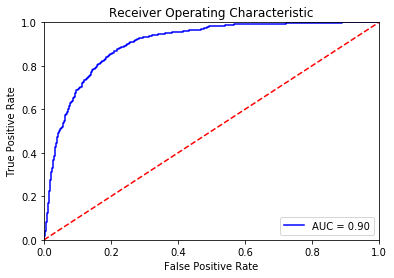

In [14]:
# Plot the RoC Curve
from sklearn.metrics import roc_curve, auc
# calculate the fpr and tpr for all thresholds of the classification
probs = logisticModel.predict_proba(X_Final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_Final, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

________________________________________________________________________________________________________
<a id="LRInterpertFeat"></a>
<a href="#top">Back to Top</a>
### Interpret Feature Importance

contact_unknown has weight of -0.6597393606569804
housing_yes has weight of -0.36483034349530163
month_jul has weight of -0.3182031838425452
month_may has weight of -0.2584796849950919
campaign has weight of -0.25795236961394996
month_aug has weight of -0.24537673422001902
month_nov has weight of -0.21238259353740632
loan_yes has weight of -0.1802869371328466
month_jan has weight of -0.1743427941843215
job_blue-collar has weight of -0.09689472462982444
poutcome_unknown has weight of -0.0837662971448729
marital_married has weight of -0.07059163186041814
job_housemaid has weight of -0.041484793114395256
job_services has weight of -0.02375225497825546
job_entrepreneur has weight of -0.021159304305913475
job_self-employed has weight of -0.019972927198734423
job_unknown has weight of -0.003907411376158106
age has weight of 0.0
contact_telephone has weight of 0.0
default_yes has weight of 0.0
job_management has weight of 0.0
job_technician has weight of 0.0
job_unemployed has weight of 0.0
m

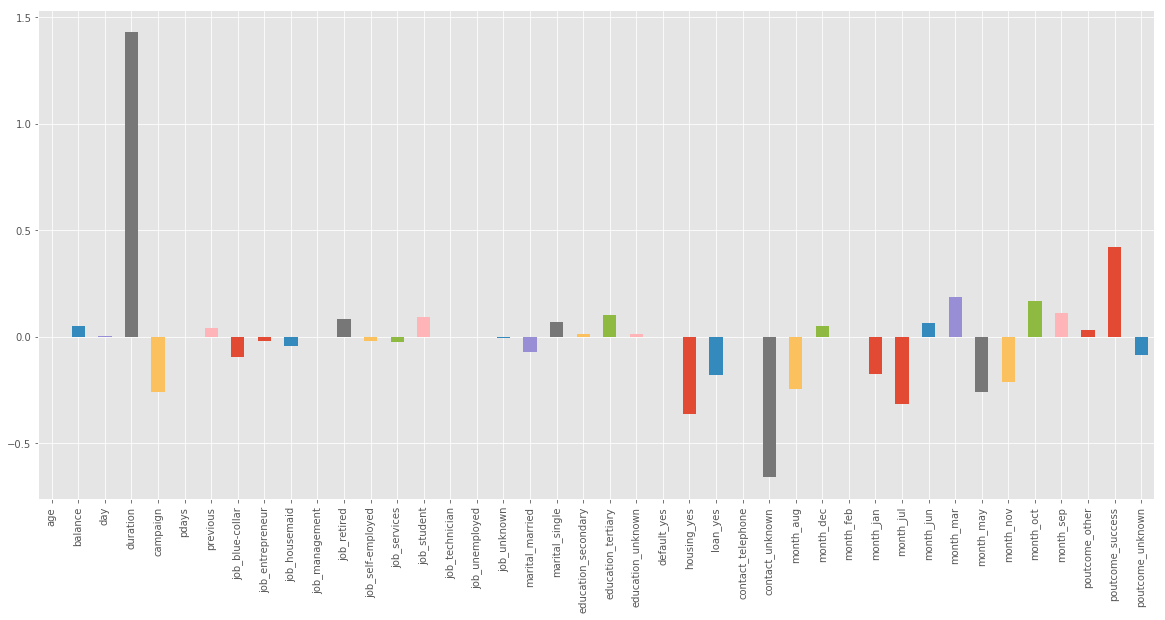

In [16]:
classifier_model = logisticModel.named_steps['logisticregression']
# sort these attributes and spit them out
zip_vars = zip(classifier_model.coef_.T, bankPromoModel_Df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0])

plt.style.use('ggplot')
plt.figure(figsize=(20,9))
weights = pd.Series(classifier_model.coef_[0],index=bankPromoModel_Df.columns)
weights.plot(kind='bar')
plt.show()

Based on the magnitude of the coefficients in above plot features- duration, contact_unknown , poutcome_success, housing_yes are among the most important features. 
- **Duration of call** is the  **most important feature in order to predict the people who want subscribe to promotion.** This is intuitive since generally, people who want subscribe to promotion want more information on the offering and providing all such details generally takes time for representative, resulting in higher call duration. The importance of this feature was quite apparent in the EDA phase.  
- **Contact_unknown** has a **higher negative coefficient**, it has a higher likelihood of predicting the people who do not want to subscribe. From EDA phase, it was determined that about 28% of callers contacted have a method listed as unknown method of communication, so it is treated as a third category. But it is also known that this promotion involved only voice calls and most likely falls into either one of the categories of cellular or telephone or both the methods of contact. Whichever way it was, it is possible that the response on phone itself was a denial and not much effort was made to record the mode of contact for these customers. 
- Next seemingly important feature is **poutcome_success with a positive coefficient** . From EDA phase , it is known that majority of the contacted people are new. But it seems that the likelihood of previously contacted customers who subscribed then and who would subscribe again is high. While it may be a tendency to ignore existing customers to fetch new ones, it would be good to contact existing customers to retain them.
- Next significant feature is **housing_yes ,i.e. customers who have a housing loan and this has a negative coefficient** presenting higher probability of not subscribing. This is intuitive since generally people who already have invested in a property have a loan and would less likely be able to invest further. Majority of the customers are belong to lower to average income households and so would have less opportunity to make multiple investments.
- From months of the year, month of July has the highest negative coefficient and is next important feature to be considered. While we are at it, we discuss the trend throughout the year. Month of Jan, May, July, Aug and Nov show higher likelihood of people not subscribing , representing summer months of vacation and winter months of important celebrations, where people may have other higher expenditures to take care of . Mar and Oct show higher likelihood of customers subscribing to term deposit.Rest of the months are less significant but more likelihood of people subscribing. 
- Another important feature is the **campaign** , i.e  number of times customer is contacted during the current campaign. Interestingly this shows a **negative coefficient**, more time contacted shows higher likelihood of not subscribing to term deposit . If a customer is interested , will respond positively in the first few contacts made. If not there could be multiple valid reasons for the customer to not invest and any number of calls made is not going to change that. 


This are some of the more significant features. Talking about the less significant ones in groups . 
- **Job related features**, have close to equal likelihood of subscribing or not subscribing to term deposit. Students , retired people and ones with corporate jobs show slightly higher likelihood of subscribing than people who are either with blue-collared jobs , entrepreneurs or people with lower income jobs like housemaids and services. 
- Education on other hand does not seem to be very significant in itself as the probability of people with any form of education and subscribing to term deposit is 50-50. Other significant features like income, loans and job may overshadow this feature. One could be highly educated but have low income maybe they are not in a well to do job or are self-employed and are just starting.On the other hand less educated people can be entrepreneurs and have high income. 
- **Age** has turned out to be one of the **least significant features**, again as it can be collinear to income or job and so the model decided it to be less significant.

________________________________________________________________________________________________________
<a id="SVMModel"></a>
<a href="#top">Back to Top</a>
### Simple SVM Model Fit

SVM also used the imputed data sets. We used two different kernels - rbf and poly. The data set is not linearly separable. So Radial Basis Function (RBF) and polynomial (poly) were tried. There were challenges in buidling a good model. The dataset is not balanced and has 89% of non-subscribed versus just 11% of subscribed. Since it is not balanced, in addition to accuracy score, recall and precision were considered in the model performance. The very first model had a decent accuracy of nearly 90%, but both recall and precision were very low (<50%). 

In [13]:
from sklearn.svm import SVC
# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

# Standardize the features first, since standardizing the features could lead to
# gradient desent algo to converge faster and then run SVM model

svmModel = make_pipeline(StandardScaler(), SVC(C=1.0, kernel='rbf', degree=3 , gamma='auto', random_state=999))

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    
    
    # train the reusable logisitc regression model on the training data
    svmModel.fit(X_train, y_train)  # train object
    y_hat = svmModel.predict(X_test) # get test set precitions

    # now let's get the accuracy,precision,recall,auc,F1 and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
  
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())

====Iteration 0  ====
confusion matrix
 [[7790  186]
 [ 739  328]]
====Iteration 1  ====
confusion matrix
 [[7847  170]
 [ 679  347]]
====Iteration 2  ====
confusion matrix
 [[7768  169]
 [ 731  375]]
====Iteration 3  ====
confusion matrix
 [[7785  194]
 [ 701  363]]
====Iteration 4  ====
confusion matrix
 [[7796  208]
 [ 689  350]]


,Accuracy,AuC,F1 Score,Precision,Recall
0,0.897711,0.642042,0.414927,0.638132,0.307404
1,0.906115,0.658501,0.449773,0.671180,0.338207
2,0.900476,0.658883,0.454545,0.689338,0.339060
3,0.901028,0.658426,0.447872,0.651706,0.341165
4,0.900807,0.655438,0.438322,0.627240,0.336862


Average Model Performnace Metrices 


Accuracy     0.901227
AuC          0.654658
F1 Score     0.441088
Precision    0.655519
Recall       0.332540
dtype: float64

________________________________________________________________________________________________________
<a id="SVMRBF"></a>
<a href="#top">Back to Top</a>
### Tuning The Model Hyper Parameters for SVM Using Grid Search
### For rbf kernel

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

param_grid = {
     'svc__kernel' : ['rbf'],
    'svc__C' : [0.1, 1, 10, 100],
    'svc__degree' : [3],
    'svc__class_weight' : [None, 'balanced'],
    'svc__gamma': [0.01, 0.1, 1,'auto']}


scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Create grid search object

clf = GridSearchCV(make_pipeline(StandardScaler(), SVC(random_state=999)), \
                   param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1, scoring=scoring, refit='AUC', \
                   return_train_score=True)

# Fit on data

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
       
    # train the reusable logisitc regression model on the training data
    clf.fit(X_train,y_train)  # train object
    y_hat = clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
  
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)
    print("Best Estimator Model Parameters\n", clf.best_params_)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())

Note: Grid search for finding optimal parameters for this SVM model took long time and we lost the output of the cell during merge process in github. Hence, we are are adding a snapshot of iteration result that we used further to build our better model.

![alt text](https://github.com/nhendersonkuns/awesomedataminers/raw/master/ReferenceMaterial/RBFGridSearchResults.PNG "RBF GRid Search Results")

________________________________________________________________________________________________________
<a id="SVMPOLY"></a>
<a href="#top">Back to Top</a>
### Tuning The Model Hyper Parameters for SVM Using Grid Search
### For poly kernel


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

param_grid = {
     'svc__kernel' : ['poly'],
    'svc__C' : [1, 5, 10],
    'svc__degree' : [3],
    'svc__class_weight' : ['balanced'],
    'svc__gamma': [0.01, 1,'auto']}


scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Create grid search object

clf = GridSearchCV(make_pipeline(StandardScaler(), SVC(random_state=999)), \
                   param_grid = param_grid, cv = 3, verbose=False, n_jobs=-1, scoring=scoring, refit='AUC', \
                   return_train_score=True)

# Fit on data

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
       
    # train the reusable logisitc regression model on the training data
    clf.fit(X_train,y_train)  # train object
    y_hat = clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
  
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)
    print("Best Estimator Model Parameters\n", clf.best_params_)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())

________________________________________________________________________________________________________
<a id="SVMFINAL"></a>
<a href="#top">Back to Top</a>
### Final SVM Model after GridSearch on Validation Dataset

In [14]:
from sklearn.svm import SVC
# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

# Standardize the features first, since standardizing the features could lead to
# gradient desent algo to converge faster and then run SVM model

svmModel = make_pipeline(StandardScaler(), SVC(C=1.0, kernel='rbf', degree=3 , gamma=0.01, class_weight = 'balanced', random_state=999))

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    
    
    # train the reusable logisitc regression model on the training data
    svmModel.fit(X_train, y_train)  # train object
    y_hat = svmModel.predict(X_test) # get test set precitions

    # now let's get the accuracy,precision,recall,auc,F1 and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
    svm_model = svmModel.named_steps['svc']
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)
    #print("Best Estimator Model Parameters\n", svm_model.best_params_)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())

====Iteration 0  ====
confusion matrix
 [[6659 1317]
 [ 137  930]]
====Iteration 1  ====
confusion matrix
 [[6737 1280]
 [ 146  880]]
====Iteration 2  ====
confusion matrix
 [[6625 1312]
 [ 125  981]]
====Iteration 3  ====
confusion matrix
 [[6664 1315]
 [ 141  923]]
====Iteration 4  ====
confusion matrix
 [[6655 1349]
 [ 121  918]]


,Accuracy,AuC,F1 Score,Precision,Recall
0,0.839213,0.853241,0.561255,0.413885,0.871603
1,0.842309,0.849020,0.552417,0.407407,0.857700
2,0.841093,0.860839,0.577229,0.427824,0.886980
3,0.838991,0.851337,0.559055,0.412422,0.867481
4,0.837443,0.857501,0.555354,0.404940,0.883542


Average Model Performnace Metrices 


Accuracy     0.839810
AuC          0.854387
F1 Score     0.561062
Precision    0.413296
Recall       0.873461
dtype: float64

- **As we can see from above performance metrics this model has performed better as compared to previous model in that the overall average AuC has improved from 0.65 to 0.84. F1 score improved from 0.44 to 0.56. Also, recall has improved significantly from 0.35 to 0.87. That said, overall accuracy decreased a little from 0.90 to 0.84 and precision drop by about 0.20. But since, overall AuC and F1 improved, by changing Prior probabilities, a balance between pricision and recall could be achieved. Moreover, in reality probabilty of people subscribing to a term deposit is not 50-50. Also, increased false positive rate means that bank would be making some extra calls that would not yield positive result but since recall is high, model is less likely to miss people who actually want to subscribe to bank deposit.**

- Even though Grid Search provided the optimum value, it took very long time to search the grid and provide optimum value. It took approx 4 hours for one iteration.

________________________________________________________________________________________________________
<a id="SVMFINAL_Test"></a>
<a href="#top">Back to Top</a>
### Final SVM Model after GridSearch on Additional Test Dataset

In [16]:
# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

# Standardize the features first, since standardizing the features could lead to
# gradient desent algo to converge faster and then run logistic regression model


svmModelAdd = make_pipeline(StandardScaler(), SVC(C=1.0, kernel='rbf', degree=3 , gamma=0.01, class_weight = 'balanced', random_state=999))

# Fit the whole training dataset now, since validation would be done on additional dataset
svmModelAdd.fit(X,y) 
y_hat = svmModelAdd.predict(X_Final) # get test set precitions

# now let's get the accuracy,precision,recall,auc,F1 and confusion matrix for this iterations of training/testing
tmpDict = dict()
tmpDict['Accuracy'] = mt.accuracy_score(y_Final,y_hat)
tmpDict['AuC'] = mt.roc_auc_score(y_Final,y_hat)
tmpDict['F1 Score'] = mt.f1_score(y_Final,y_hat)
tmpDict['Precision'] = mt.precision_score(y_Final,y_hat)
tmpDict['Recall'] = mt.recall_score(y_Final,y_hat)
    
modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

conf = mt.confusion_matrix(y_Final,y_hat)
  
print("confusion matrix\n",conf)
    
print("\n Model Performnace Metrices")
display(modelPerformanceMetrices)


confusion matrix
 [[3300  700]
 [  48  473]]

 Model Performnace Metrices


,Accuracy,AuC,F1 Score,Precision,Recall
0,0.83455,0.866435,0.558442,0.40324,0.907869


**In conclusion, the results obtained for classification performance metrices(AuC, accuracy, F1 score etc) on the additional test dataset are very close to those obtained on cross-validation dataset. And final model is performing significantly better(in terms of overall AuC values) than the initial svm model the one without hyperparameters tuning.** 

________________________________________________________________________________________________________
<a id="MODELADV"></a>
<a href="#top">Back to Top</a>
# Model Advantages

In SVM, finding the optimum hyper parameters took very long time. For poly and rbf kernels, it took hours to find the best parameter. 

Once the best parameters were found for each kernels, then individual models ran fast.

Both Support Vector Machine (SVM) and Logistic Regression (LR) try to classify a binary response or maximizing the probability of classifying a response variable.  In these models the team is trying to classify a response variable of subscribing to a long-term deposit.

The SVM model attempts to find the maximum margin in the dimensional space.  This space is defined by the number of features that classify data points.  Points that fall on either side of this plane are classified into one of the binary responses the model is predicting.  To accurately define these margins the model uses support vectors that define the boundaries or the max margin.  These support vectors are points that lie the closest to the calculated boundary of the points.  These support vectors also define the position of the optimized plane.

![alt text](https://github.com/nhendersonkuns/awesomedataminers/raw/master/ReferenceMaterial/SVM_optimal_plane.PNG "SVM Planes")

The LR model will take the output of you model and give you a response that is between 0 and 1 using the logistic function.  In the case that the output is higher or lower than your threshold the value will be give a 1 or 0 respectively.  Within LR the method is to maximize the likelihood that a random data point is classified correctly (maximum likelihood estimation, MLE).  The LR allows the model to optimize this function by use of algorithms such as Newton’s method, conjugate gradients, modifications of Newton’s method using box constraints.  Learning and applying the different methods allow for a more accurate model.

The difference between SVM and LR in terms of the Loss function is that SVM will minimize hinge loss while LR minimizes logistic loss.  What this leads to is logistic loss (LR) diverges faster than hinge loss (SVM).  The LR model is more sensitive to outliers as it tries to find the plane for classifying the points, where as the SVM model is not as sensitive to these outliers.

![alt text](https://github.com/nhendersonkuns/awesomedataminers/raw/master/ReferenceMaterial/Outliers_SVM_vs_LR.PNG "SVM vs LR Outliers")

Within the LR model your values are predicted probabilities between 0 and 1, which at this point you must decide your cut-off to give you the binary response.  The SVM model does produce a final binary response of 0 or 1.

LR will perform better on smaller data sets and SVM performs better with larger data sets.  In terms of small data sets SVM as support vectors may not be a true/good representation of the decision boundaries.  Deciding the performance between SVM and LR, is relative and depends on several factors such as data set size and domain knowledge of the data.  In most cases a simple model (LR) should be attempted first to determine if the output is of desired accuracy.  In tradition LR it is found that the models may fit the training data set to well and may result in a model that is unable to make reasonably good predictions for unknown data points which is referred to as overfitting.  SVM attempts to minimize the classification error on the training set and minimize the complexity of the model.  Over all between the two methods SVM can compute more complex decision boundaries.

**In the case of the bank data set, the team believes that the SVM should provide better results due to the size of the data sets and several outlier points that were discovered during data discovery.   Ultimately, the SVM model performed just as well as the logistic model in our case.  However, the major difference between the two models was the time for the SVM to run and the SVM model's benefit did not outweigh the time that was spent for it to run.**


________________________________________________________________________________________________________
<a id="INTVECT"></a>
<a href="#top">Back to Top</a>
# Interpret Support Vector

In [23]:
svm_model = svmModel.named_steps['svc']

In [25]:
# look at the support vectors
print(svm_model.support_vectors_.shape)
print(svm_model.support_.shape)
print(svm_model.n_support_ )

(13577, 42)
(13577,)
[11695  1882]


There are in total 13577 support vectors.

The total number of different support vectors are 13577.The total number postive support vecotrs for those that subscribed are 
11695.The total number of negative support vectors for those that did not subscribe are 1822.

In [30]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = bankPromoModel_Df.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_model.support_,:]

df_support['Target'] = y[svm_model.support_] # add back in the 'Survived' Column to the pandas dataframe
bankPromoModel_Df['Target'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13577 entries, 41197 to 42930
Data columns (total 43 columns):
age                    13577 non-null int64
balance                13577 non-null int64
day                    13577 non-null int64
duration               13577 non-null int64
campaign               13577 non-null int64
pdays                  13577 non-null int64
previous               13577 non-null int64
job_blue-collar        13577 non-null uint8
job_entrepreneur       13577 non-null uint8
job_housemaid          13577 non-null uint8
job_management         13577 non-null uint8
job_retired            13577 non-null uint8
job_self-employed      13577 non-null uint8
job_services           13577 non-null uint8
job_student            13577 non-null uint8
job_technician         13577 non-null uint8
job_unemployed         13577 non-null uint8
job_unknown            13577 non-null uint8
marital_married        13577 non-null uint8
marital_single         13577 non-null uint8
educati

C:\Users\KRamasundaram\Anaconda3\envs\MLEnv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


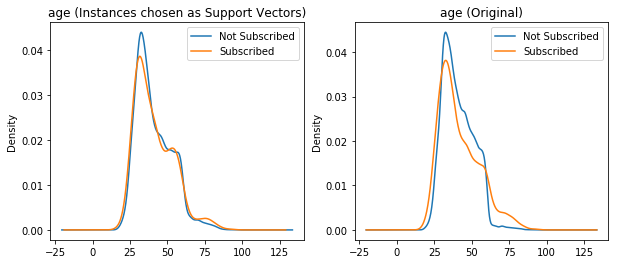

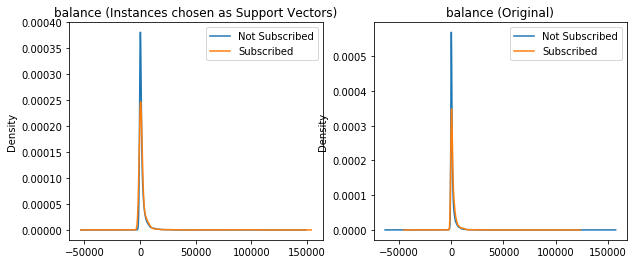

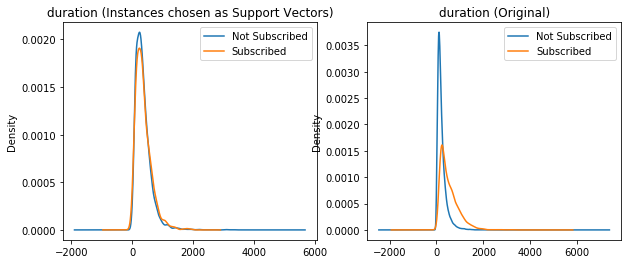

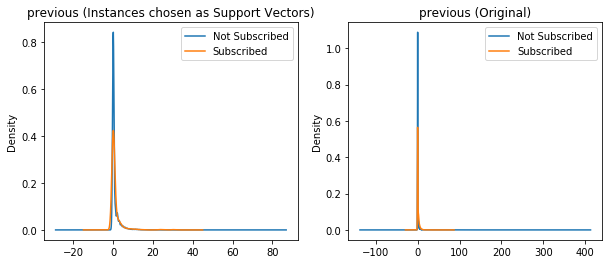

In [32]:
# now lets see the statistics of these attributes
#from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Target'])
df_grouped = bankPromoModel_Df.groupby(['Target'])

# plot KDE of Different variables
vars_to_plot = ['age', 'balance', 'duration','previous']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not Subscribed','Subscribed'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not Subscribed','Subscribed'])
    plt.title(v+' (Original)')

Based on the visual examination of the plots, the original data and support vectors look very close. Actually the separation is lot greater in the original data than what is shown in the plots. The reason is that the support vector instances are the data points that are only on the edge of the class boundary and classified incorrectly.

________________________________________________________________________________________________________
<a id="ECPWORK"></a>
<a href="#top">Back to Top</a>
# Exceptional Work
## Running Polynomial Logistic Regression 

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])

# Standardize the features first, since standardizing the features could lead to
# gradient desent algo to converge faster and then run logistic regression model

logisticModel = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=999))

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
       
    # train the reusable logisitc regression model on the training data
    logisticModel.fit(X_train,y_train)  # train object
    y_hat = logisticModel.predict(X_test) # get test set precitions

    # now let's get the accuracy,precision,recall,auc,F1 and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
  
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====Iteration 0  ====
confusion matrix
 [[7681  295]
 [ 582  485]]
====Iteration 1  ====
confusion matrix
 [[7712  305]
 [ 560  466]]
====Iteration 2  ====
confusion matrix
 [[7654  283]
 [ 595  511]]
====Iteration 3  ====
confusion matrix
 [[7674  305]
 [ 588  476]]
====Iteration 4  ====
confusion matrix
 [[7671  333]
 [ 558  481]]


,Accuracy,AuC,F1 Score,Precision,Recall
0,0.903019,0.708780,0.525176,0.621795,0.454545
1,0.904346,0.708073,0.518642,0.604410,0.454191
2,0.902908,0.713185,0.537895,0.643577,0.462025
3,0.901250,0.704572,0.515989,0.609475,0.447368
4,0.901471,0.710670,0.519158,0.590909,0.462945


Average Model Performnace Metrices 


Accuracy     0.902599
AuC          0.709056
F1 Score     0.523372
Precision    0.614033
Recall       0.456215
dtype: float64

As seen from output above, we see that polynomial model(having higher complexity than earlier model) is having much better AuC, Precision and recall scores and at higher accuracy, even without hyper parameters tuning. This points to the fact that our earlier model was underfitting and we need to add complexity to it to achieve better results.
Next we would perform grid search to tune hyper parameters of this polynomial logistic regression model.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.simplefilter('ignore', UserWarning)

# Initialize an Empty Dataframe to store Model performance Stats
modelPerformanceMetrices = pd.DataFrame(columns=['Accuracy', 'AuC', 'F1 Score', 'Precision', 'Recall'])


param_grid = {
     'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C' : np.logspace(-4, 4, 50),
    'logisticregression__solver' : ['liblinear'],
    'logisticregression__class_weight' : [None, 'balanced']}


# Create grid search object
# Trying to find params that lead to maximum F1 Score
clf = GridSearchCV(make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LogisticRegression(random_state=999)), \
                   param_grid = param_grid, cv = 5, verbose=False, n_jobs=-1, scoring='f1')

# Fit on data

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
       
    # train the reusable logisitc regression model on the training data
    clf.fit(X_train,y_train)  # train object
    y_hat = clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    tmpDict = dict()
    tmpDict['Accuracy'] = mt.accuracy_score(y_test,y_hat)
    tmpDict['AuC'] = mt.roc_auc_score(y_test,y_hat)
    tmpDict['F1 Score'] = mt.f1_score(y_test,y_hat)
    tmpDict['Precision'] = mt.precision_score(y_test,y_hat)
    tmpDict['Recall'] = mt.recall_score(y_test,y_hat)
    
    modelPerformanceMetrices = modelPerformanceMetrices.append(tmpDict, ignore_index=True)

    conf = mt.confusion_matrix(y_test,y_hat)
  
    print("====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)
    print("Best Estimator Model Parameters\n", clf.best_params_)

display(modelPerformanceMetrices)
print("Average Model Performnace Metrices ")
display(modelPerformanceMetrices.mean())

### Running Recursive Feature Elimination to Reduce Curse of Dimensionality

Run the RFE in CV mode, in 5 Fold CV there would be 5 passes and in each pass features that are not that important to classification task are listed as output.
Remove a feature from the dataset, if the feature is marked for elimination by RFE in 2 passes out of 5.
Recreate the dataset with only non-eliminated features and fit the model again on this dataset.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.exceptions import DataConversionWarning
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

featureSelectionArr = np.full((len(bankPromoModel_Df.columns)), True)

# Standardize the features first, since standardizing the features could lead to
# gradient desent algo to converge faster and then run logistic regression model
scl_obj = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # Standardize the train dataset and then apply the transform the test data. 
    scl_obj.fit(X_train)
    X_train_scaled = scl_obj.transform(X_train)
    X_test_scaled = scl_obj.transform(X_test)
    
    # train the reusable logisitc regression model on the training data
#    lr_clf.fit(X_train_scaled,y_train)  # train object

    rfe = RFE(lr_clf, 25)
    fit = rfe.fit(X_train_scaled,y_train)  # train object

    featureSelectionArr = np.vstack((featureSelectionArr, fit.support_ ))
    


In [14]:
# remove the first row in feature array as it was dummy row.
featureSelectionArr = featureSelectionArr[1: , :]

In [15]:
# Keep only those feature that appear important in 3 out of 5 passes.
bankPromoModel_Df.columns[np.sum(featureSelectionArr, axis = 0) >= 3]

Index(['day', 'duration', 'campaign', 'job_blue-collar', 'job_retired',
       'job_student', 'marital_married', 'education_secondary',
       'education_tertiary', 'education_unknown', 'housing_yes', 'loan_yes',
       'contact_unknown', 'month_aug', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_success'],
      dtype='object')

In [16]:
# Make a copy of original data frame
bankPromoModel_Df_1 = bankPromo_df.copy()
bankPromoModel_Df_1['Target'] = bankPromoModel_Df_1['Subscribed'].apply(lambda resp : 1 if resp == "yes" else 0)
bankPromoModel_Df_1['Target'] = bankPromoModel_Df_1['Target'].astype(np.int)
# Delete the original 'Subscribed' column
del bankPromoModel_Df_1['Subscribed']

In [17]:
# Covert all categorical variables to corresponding indicator variables
categoricalVarsToBeUsed = ['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

for categoricalVar in categoricalVarsToBeUsed:
    tmpDf = pd.DataFrame()
    # Remove 1st class level to avoid multicollinearity
    tmpDf = pd.get_dummies(bankPromoModel_Df_1[categoricalVar], prefix=categoricalVar, drop_first=True)
    bankPromoModel_Df_1 = pd.concat((bankPromoModel_Df_1, tmpDf), axis=1)

# Now remove the original categorical vars since indicator variables are created from them.
bankPromoModel_Df_1.drop(categoricalVars, inplace=True, axis=1)

# Now remove non useful numerical variables
bankPromoModel_Df_1.drop(['age', 'balance', 'pdays', 'previous'], inplace=True, axis=1)
bankPromoModel_Df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 38 columns):
day                    45211 non-null int64
duration               45211 non-null int64
campaign               45211 non-null int64
Target                 45211 non-null int64
job_blue-collar        45211 non-null uint8
job_entrepreneur       45211 non-null uint8
job_housemaid          45211 non-null uint8
job_management         45211 non-null uint8
job_retired            45211 non-null uint8
job_self-employed      45211 non-null uint8
job_services           45211 non-null uint8
job_student            45211 non-null uint8
job_technician         45211 non-null uint8
job_unemployed         45211 non-null uint8
job_unknown            45211 non-null uint8
marital_married        45211 non-null uint8
marital_single         45211 non-null uint8
education_secondary    45211 non-null uint8
education_tertiary     45211 non-null uint8
education_unknown      45211 non-null uint8
housing_yes

In [18]:
# Training and Test Split
from sklearn.model_selection import ShuffleSplit

if 'Target' in bankPromoModel_Df_1:
    y = bankPromoModel_Df_1['Target'].values # get the labels we want
    del bankPromoModel_Df_1['Target']        # get rid of the class label
    X = bankPromoModel_Df_1.values           # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# To use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


In [19]:
# Fitting the model on reduced dataset
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

degrees = np.arange(1, 2)

model = make_pipeline(StandardScaler(),LogisticRegression(penalty='l2', C=1.0, class_weight=None))

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
       
    # train the reusable logisitc regression model on the training data
    model.fit(X_train,y_train)  # train object
    y_hat = model.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    pre = mt.precision_score(y_test,y_hat)
    rec = mt.recall_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("AuC", auc )
    print("accuracy", acc )
    print("precision", pre)
    print("recall", rec)
    print("confusion matrix\n",conf)

====Iteration 0  ====
AuC 0.6739314015106648
accuracy 0.9036824062811014
precision 0.6426229508196721
recall 0.3751196172248804
confusion matrix
 [[7780  218]
 [ 653  392]]
====Iteration 1  ====
AuC 0.6616923650142005
accuracy 0.9004755059161783
precision 0.679144385026738
recall 0.3460490463215259
confusion matrix
 [[7762  180]
 [ 720  381]]
====Iteration 2  ====
AuC 0.6585424797495267
accuracy 0.8987061815769103
precision 0.6654867256637168
recall 0.34088848594741616
confusion matrix
 [[7751  189]
 [ 727  376]]
====Iteration 3  ====
AuC 0.6564178240475862
accuracy 0.9006966714585868
precision 0.6230088495575221
recall 0.3394406943105111
confusion matrix
 [[7793  213]
 [ 685  352]]
====Iteration 4  ====
AuC 0.6584398523251191
accuracy 0.9036824062811014
precision 0.6635514018691588
recall 0.33938814531548755
confusion matrix
 [[7817  180]
 [ 691  355]]


As we can see from above output that even after performing recursive feature elimination(RFE), our model performance metrics are not very different from the that of initial simple logistic regression model. Hence, we would be keeping all features in model and rely upon regularization to prevent our model from overfitting. 